In [1]:
#creates connectivity matrix
import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image, input_data, datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()
#subs = ['sub-107'] #temporary checking the matrix for one subject

run_num = 3
runs = list(range(1, run_num + 1))

# Define the number of ROIs for the Schaefer atlas
n_rois = 200

def verify_standard_space(img):
    """Verify image is in 2mm standard space"""
    if img.shape[:3] != (91, 109, 91):
        logging.warning(f"Unexpected shape: {img.shape}")
        return False
    
    vox_size = np.sqrt(np.sum(img.affine[:3, :3] ** 2, axis=0))
    if not np.allclose(vox_size, [2., 2., 2.], atol=0.1):
        logging.warning(f"Unexpected voxel size: {vox_size}")
        return False
    
    return True

def create_connectivity_matrix(ss):
    """Create connectivity matrix using standard space data"""
    logging.info(f"Processing subject: {ss}")
    
    # Load Schaefer atlas (already in MNI 2mm space)
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2)
    atlas_img = atlas.maps
    
    all_runs_data = []
    
    for rn in runs:
        # Load standard space data
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/reg_standard/filtered_func_data_standard.nii.gz'
        if not os.path.exists(run_path):
            logging.warning(f'Standard space data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        
        # Verify standard space
        if not verify_standard_space(subject_img):
            logging.warning(f"Data not in expected standard space for {ss} run-{rn}")
            continue
        
        # Extract time series using the atlas
        masker = NiftiLabelsMasker(
            labels_img=atlas_img,
            standardize=True,
            memory='nilearn_cache',
            verbose=0
        )
        
        time_series = masker.fit_transform(subject_img)
        all_runs_data.append(time_series)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    
    return connectivity_matrix

def main():
    for ss in subs:
        connectivity_matrix = create_connectivity_matrix(ss)
        if connectivity_matrix is not None:
            # Save with modified filename to indicate standard space
            output_dir = f'{results_dir}/connectivity_matrices_{n_rois}_standard'
            os.makedirs(output_dir, exist_ok=True)
            np.save(f'{output_dir}/{ss}_connectivity_matrix_standard.npy', connectivity_matrix)
            logging.info(f'Saved standard space connectivity matrix for {ss}')

if __name__ == "__main__":
    main()

2024-11-11 18:33:57,190 - INFO - Processing subject: sub-025
2024-11-11 18:34:48,637 - INFO - Saved standard space connectivity matrix for sub-025
2024-11-11 18:34:48,638 - INFO - Processing subject: sub-038
2024-11-11 18:35:39,022 - INFO - Saved standard space connectivity matrix for sub-038
2024-11-11 18:35:39,023 - INFO - Processing subject: sub-057
2024-11-11 18:36:28,114 - INFO - Saved standard space connectivity matrix for sub-057
2024-11-11 18:36:28,115 - INFO - Processing subject: sub-059
2024-11-11 18:37:17,633 - INFO - Saved standard space connectivity matrix for sub-059
2024-11-11 18:37:17,634 - INFO - Processing subject: sub-064
2024-11-11 18:38:05,775 - INFO - Saved standard space connectivity matrix for sub-064
2024-11-11 18:38:05,776 - INFO - Processing subject: sub-067
2024-11-11 18:38:55,021 - INFO - Saved standard space connectivity matrix for sub-067
2024-11-11 18:38:55,023 - INFO - Processing subject: sub-068
2024-11-11 18:39:43,483 - INFO - Saved standard space con

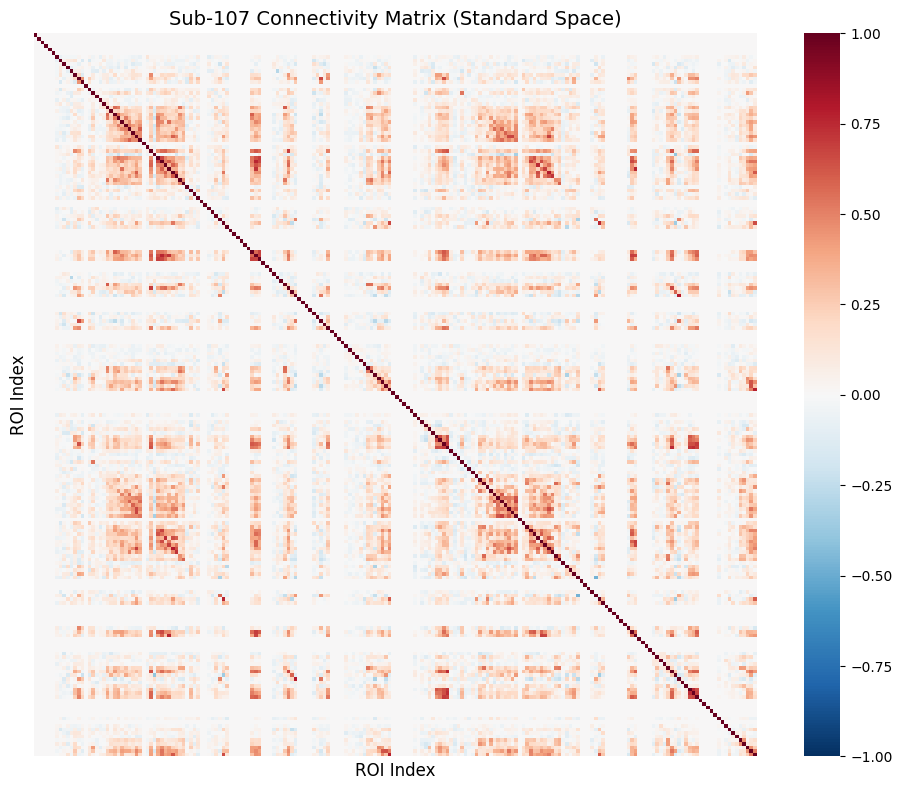

Matrix shape: (200, 200)
Mean correlation: 0.047
Standard deviation: 0.134
Min correlation: -0.471
Max correlation: 1.000


In [ ]:
#pre standardizing the data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the connectivity matrix
conn_matrix = np.load('results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy')

# Create figure with specific size
plt.figure(figsize=(10, 8))

# Create heatmap using seaborn
# Using 'RdBu_r' colormap which is good for correlation data (red-blue, reversed)
sns.heatmap(conn_matrix, 
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            xticklabels=False,
            yticklabels=False)

# Add title and labels
plt.title('Sub-107 Connectivity Matrix (Standard Space)', fontsize=14)
plt.xlabel('ROI Index', fontsize=12)
plt.ylabel('ROI Index', fontsize=12)

# Add colorbar label
#plt.colorbar(label='Correlation Coefficient')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print some basic statistics about the connectivity matrix
print(f"Matrix shape: {conn_matrix.shape}")
print(f"Mean correlation: {np.mean(conn_matrix):.3f}")
print(f"Standard deviation: {np.std(conn_matrix):.3f}")
print(f"Min correlation: {np.min(conn_matrix):.3f}")
print(f"Max correlation: {np.max(conn_matrix):.3f}")

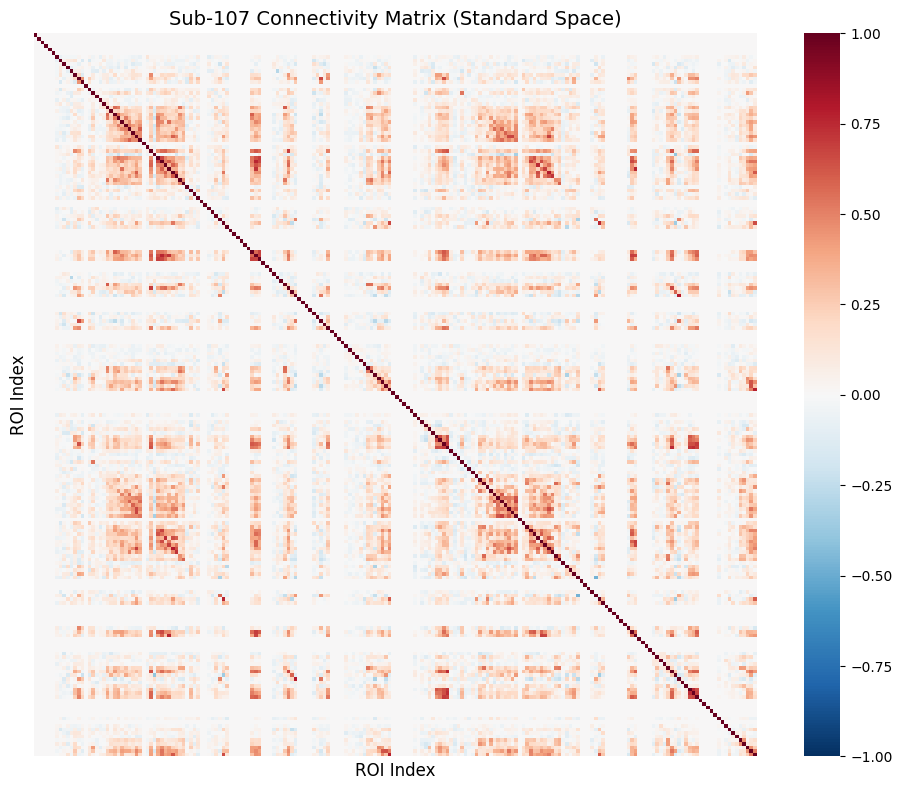

Matrix shape: (200, 200)
Mean correlation: 0.047
Standard deviation: 0.134
Min correlation: -0.471
Max correlation: 1.000


In [7]:
# post standardizing data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the connectivity matrix
conn_matrix = np.load('results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy')

# Create figure with specific size
plt.figure(figsize=(10, 8))

# Create heatmap using seaborn
# Using 'RdBu_r' colormap which is good for correlation data (red-blue, reversed)
sns.heatmap(conn_matrix, 
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            xticklabels=False,
            yticklabels=False)

# Add title and labels
plt.title('Sub-107 Connectivity Matrix (Standard Space)', fontsize=14)
plt.xlabel('ROI Index', fontsize=12)
plt.ylabel('ROI Index', fontsize=12)

# Add colorbar label
#plt.colorbar(label='Correlation Coefficient')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print some basic statistics about the connectivity matrix
print(f"Matrix shape: {conn_matrix.shape}")
print(f"Mean correlation: {np.mean(conn_matrix):.3f}")
print(f"Standard deviation: {np.std(conn_matrix):.3f}")
print(f"Min correlation: {np.min(conn_matrix):.3f}")
print(f"Max correlation: {np.max(conn_matrix):.3f}")